# Data Explorations given external csv files

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import os

In [2]:
bv = pd.read_csv("../references/external/bill_version.csv", sep=";", encoding="latin1", parse_dates=True)
sessions =  pd.read_csv("../references/external/session.csv", sep=";", encoding="latin1", parse_dates=True)
bills =  pd.read_csv("../references/external/bill.csv", sep=";", encoding="latin1", parse_dates=True)
divs =  pd.read_csv("../references/external/division.csv", sep=";", encoding="latin1", parse_dates=True)
bill_leg_vote =  pd.read_csv("../references/external/bill_legislator_vote.csv", sep=";", encoding="latin1", parse_dates=True)
vote_rec_type =  pd.read_csv("../references/external/vote_recorded_type.csv", sep=";", encoding="latin1", parse_dates=True)

In [4]:
if 'DATA_VOL' not in os.environ:
    # Manually set:
    DATA_VOL = '/home/luke/datavol/'
else:
    DATA_VOL = os.environ['DATA_VOL']
print(DATA_VOL)
version_exists = []
for i in bv['id']:
    fn = DATA_VOL + 'clean/' + str(i) + '.txt'
    #print(fn)
    if os.path.exists(fn):
        version_exists.append(True)
    else:
        version_exists.append(False)
print(len(bv))
print(sum(version_exists))
bv = bv[version_exists]

/home/luke/datavol/
615357
615357


In [5]:
# Data Cleaning:
# One bill version has no bill_id
bills = bills[~bills.chamber_id.isna()]
bills.chamber_id = bills.chamber_id.astype(int)


for col in bills[['signed', 'passed_lower', 'passed_upper' ]]:
    mask = bills[col].isna()
    bills.loc[mask, col] = 0
    mask = bills[col]!=0
    bills.loc[mask, col] = 1

In [6]:
divs.head()

,id,identifier,name,abbr,has_data,division_type_id,division_level_id,same_as,parent_id,valid_through,valid_from,thread_id,timezone_id
0,651,ocd-division/country:us/state:ak,Alaska,AK,1,10,1,NaN,1.0,NaN,NaN,1,54.0
1,1421,ocd-division/country:us/state:al,Alabama,AL,1,10,1,NaN,1.0,NaN,NaN,1,88.0
2,4979,ocd-division/country:us/state:ar,Arkansas,AR,1,10,1,NaN,1.0,NaN,NaN,1,88.0
3,193348,ocd-division/country:us/territory:as,American Samoa,AS,0,35,1,NaN,1.0,NaN,NaN,1,NaN
4,9178,ocd-division/country:us/state:az,Arizona,AZ,1,10,1,NaN,1.0,NaN,NaN,1,164.0


Asks from Tim:

* Political control of each chamber.
* states corresponding to each state_id
* Chamber_id? 1=Lower, 2=Upper?


# Bill Versions

id: primary key
name: Captured name text from original source
mimetype: content type
url: S3 location after hashing
bill_id: foreign key to the bills table

# Bills

id: primary key
chamber_id: 1=house, 2=senate
session_id: foreign key to chamber table
division_id: State/territory id
passed_upper: boolean (also missing)
passed_lower: boolean (also missing)
signed: boolean (also missing)

# Sessions

id: primary key
division_id: State/territory id
in_session: boolean, is session done yet

# Division

id: primary key
abbr: state abbreviation


Interesting questions and TODOS:

* How many unique bills are there?
* What time frame are we dealing with?
* What state has the most/least bills?
* What state passed the most legislation?
* Get a story together about the versioning process
* 

* 53 jurisdictions. created_at runs from 2018-2020

-- 247,565 unique bills
-- What is state_id = 53 with very very few bills passed.

In [7]:
# Number of unique bills per state. How many passed each chamber.
df = bills.merge(divs, left_on="division_id", right_on="id")
df[['abbr', "signed", "passed_upper", "passed_lower", "has_data"]].groupby("abbr").agg(["count"]).sort_values('abbr').head()

,signed,passed_upper,passed_lower,has_data
,count,count,count,count
abbr,,,,
AK,664,664,664,664
AL,2421,2421,2421,2421
AR,2037,2037,2037,2037
AZ,2997,2997,2997,2997
CA,5388,5388,5388,5388


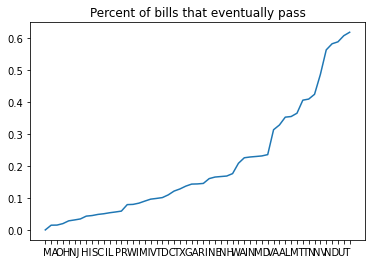

<Figure size 720x432 with 0 Axes>

In [8]:
df = df[['abbr', 'passed_lower', 'passed_upper', 'signed']]
df = df.fillna(0)
for col in df.columns[1:]:
    mask = df[col]!=0
    df.loc[mask, col] = 1
df = df.astype({"abbr":str, "signed": int, "passed_upper": int, "passed_lower":int})
passage_agg = df.groupby('abbr').agg(["mean", "count"])
#sm = passage_agg['signed']['count'].sort_values(axis=0)
sm = passage_agg['signed']['mean'].sort_values(axis=0)


fig, ax = plt.subplots()
ax.plot( range(len(sm)), sm.values)
plt.xticks(ticks = [])
ax.set_xticks(range(len(sm)))
ax.set_xticklabels(sm.index.values)
#plt.label = 'xx'
ax.set_title("Percent of bills that eventually pass")
#fig.sup_title = ""

matplotlib.rcParams['figure.figsize'] = [10,6]

# Thin the x-axis labels for visibility
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
    
plt.show()
plt.savefig("passage_fraction.png")

In [9]:
# Calculate the version number of the bill.

# NOTES: Updated_at may potentialy be the same for each bill_id, we order by the id in this case
a = bv
a['version_number'] = a[['id', 'bill_id', 'updated_at']].groupby('bill_id').cumcount()+1
a[['id', 'bill_id', 'version_number', 'updated_at']].sort_values('bill_id').tail(n=100)

,id,bill_id,version_number,updated_at
615166,2743086,1347140,3,2020-08-07 20:47:51
615165,2743085,1347140,2,2020-08-07 20:47:51
615164,2743084,1347140,1,2020-08-07 20:47:50
615167,2743087,1347142,1,2020-08-07 20:48:01
615169,2743089,1347142,3,2020-08-07 20:48:03
...,...,...,...,...
615238,2743158,1347259,1,2020-08-08 02:16:56
615240,2743160,1347260,1,2020-08-08 02:17:07
615241,2743161,1347261,1,2020-08-08 02:17:20
615242,2743162,1347262,1,2020-08-08 02:17:30


In [10]:
a[['bill_id', 'name', 'id', 'version_number']].sort_values('version_number', ascending=False).head(n=100)

,bill_id,name,id,version_number
225855,1211737,"Section 15-18- Appropriations Clauses, Safety ...",2350546,223
225854,1211737,Section 14- FY 2018-19 Public Health & Environ...,2350545,222
225853,1211737,Section 13- FY 2018-19 Personnel (04/17/2019),2350544,221
225852,1211737,Section 12- FY 2018-19 Judicial (04/17/2019),2350543,220
225851,1211737,Section 11- FY 2018-19 Human Services (04/17/2...,2350542,219
...,...,...,...,...
210299,1211737,Natural Resources (04/05/2019),2334939,164
418463,1301160,995079 - Amendment to S 2500 Filed,2544386,164
557461,1337882,Law (06/12/2020),2685381,164
557460,1337882,Labor (06/12/2020),2685380,163


In [11]:
pl      = pd.read_csv("../references/derived/partisan_lean.csv", sep=",", encoding="latin1", parse_dates=True)
#doc_len = pd.read_csv("../notebooks/doc_len.csv")

In [12]:
ml_data = a[['id', 'version_number', 'bill_id']].merge(bills[['id', 'signed', 'session_id', 'passed_lower', 'passed_upper', 'chamber_id']].rename(columns={'id':"bill_id"}), on='bill_id')
ml_data = ml_data.merge(pl[['session_id', 'chamber_id', 'partisan_lean']], on=['session_id', 'chamber_id'])
ml_data = ml_data.fillna(0)


In [22]:
ml_data['passed'] = ml_data['passed_lower']*(ml_data['chamber_id']==1) + ml_data['passed_upper']*(ml_data['chamber_id']==2)
ml_data[ml_data.passed_lower==1]

,id,version_number,bill_id,signed,session_id,passed_lower,passed_upper,chamber_id,partisan_lean,passed
11,2127866,1,1098149,1,562,1,1,1,0.236118,1
14,2128986,1,1098872,1,562,1,1,1,0.236118,1
15,2128987,1,1098873,1,562,1,1,1,0.236118,1
16,2129001,1,1098887,1,562,1,1,1,0.236118,1
17,2129227,1,1099089,1,562,1,1,1,0.236118,1
...,...,...,...,...,...,...,...,...,...,...
496157,2676412,1,1339106,0,645,1,0,2,0.317073,0
496158,2676413,1,1339107,0,645,1,1,2,0.317073,1
496159,2676414,2,1339107,0,645,1,1,2,0.317073,1
496186,2607306,1,1330964,0,649,1,1,1,0.341463,1


,id,version_number,bill_id,signed,session_id,passed_lower,passed_upper,chamber_id,partisan_lean
496253,2740636,1,1346334,0,666,0,0,2,0.525
496254,2740995,1,1346470,0,666,0,0,2,0.525
496255,2741134,1,1346569,0,666,0,0,2,0.525
496256,2741135,1,1346570,0,666,0,0,2,0.525
496257,2742709,1,1347123,0,666,0,0,2,0.525


In [23]:
ml_data['sc_id'] = ml_data['session_id'].astype(str) + "-" + ml_data['chamber_id'].astype(str)
ml_data = ml_data[['id', 'version_number', 'bill_id', 'signed', 'passed', 'partisan_lean',  'sc_id']]

In [24]:
s1 = ml_data[['bill_id', 'id']].groupby('bill_id').sample(1)
ml_data = ml_data.merge(s1, on = ['id', 'bill_id'])

In [25]:
ml_data.head()

,id,version_number,bill_id,signed,passed,partisan_lean,sc_id
0,2119301,1,1092981,0,0,0.236118,562-1
1,2127866,1,1098149,1,1,0.236118,562-1
2,2127963,1,1098199,0,0,0.236118,562-1
3,2128334,1,1098465,0,0,0.236118,562-1
4,2128986,1,1098872,1,1,0.236118,562-1


In [26]:
ml_data.to_csv('../references/derived/ml_data.csv', index=False)

In [27]:
df2 = pd.read_csv("../references/derived/ml_data.csv", encoding="latin1", parse_dates=True)
df2.head()

,id,version_number,bill_id,signed,passed,partisan_lean,sc_id
0,2119301,1,1092981,0,0,0.236118,562-1
1,2127866,1,1098149,1,1,0.236118,562-1
2,2127963,1,1098199,0,0,0.236118,562-1
3,2128334,1,1098465,0,0,0.236118,562-1
4,2128986,1,1098872,1,1,0.236118,562-1


In [28]:
ml_data.head()

,id,version_number,bill_id,signed,passed,partisan_lean,sc_id
0,2119301,1,1092981,0,0,0.236118,562-1
1,2127866,1,1098149,1,1,0.236118,562-1
2,2127963,1,1098199,0,0,0.236118,562-1
3,2128334,1,1098465,0,0,0.236118,562-1
4,2128986,1,1098872,1,1,0.236118,562-1


In [29]:
ml_data.shape

(199646, 7)

In [31]:
import numpy as np
np.mean(ml_data.passed)

0.15937709746250864

In [32]:
np.mean(ml_data.signed)

0.13822465764402994